<a href="https://colab.research.google.com/github/yueshao031/ra65_yueshao_assignment3/blob/RL_part2/ra65_yueshao_assignment3_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.9 MB/s eta 0:00:00


In [2]:
# Import required libraries
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import time

## Envirnoment Setup from Part 1

In [3]:
# Definition of the Grid Environment class.

class GridEnvironment(gym.Env):
  # Attribute of a Gym class that provides info about the render modes
  metadata = { 'render.modes': [] }

  # Initialization function
  def __init__(self):

    self.environment_width = 5
    self.environment_height = 5

    self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
    self.action_space = spaces.Discrete(4)
    #self.max_timesteps = 10

    self.timestep = 0
    self.agent_pos = [4, 0]
    self.goal_pos = [1, 3]
    self.battery_pos = [1, 0]
    self.super_battery_pos = [1, 2]
    self.rock1_pos = [4, 2]
    self.rock2_pos = [3, 3]
    self.battery_quantity = 1
    self.super_battery_quantity = 1
    self.rock1_quantity = 1
    self.rock2_quantity = 1
    self.state = np.zeros((5,5))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.battery_pos)] = 2
    self.state[tuple(self.super_battery_pos)] = 3
    self.state[tuple(self.rock1_pos)] = 4
    self.state[tuple(self.rock2_pos)] = 4
    self.state[tuple(self.goal_pos)] = 5

  # Reset function
  def reset(self, **kwargs):
    self.agent_pos = [4, 0]
    self.goal_pos = [1, 3]
    self.battery_pos = [1, 0]
    self.super_battery_pos = [1, 2]
    self.rock1_pos = [4, 2]
    self.rock2_pos = [3, 3]
    self.battery_quantity = 1
    self.super_battery_quantity = 1
    self.rock1_quantity = 1
    self.rock2_quantity = 1
    self.state = np.zeros((5,5))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.battery_pos)] = 2
    self.state[tuple(self.super_battery_pos)] = 3
    self.state[tuple(self.rock1_pos)] = 4
    self.state[tuple(self.rock2_pos)] = 4
    self.state[tuple(self.goal_pos)] = 5
    observation = self.state.flatten()

    info = {}

    return observation, info

  # Step function: Contains the implementation for what happens when an
  # agent takes a step in the environment.
  def step(self, action):

    if action == 0: #down
      self.agent_pos[0] += 1
    if action == 1: #up
      self.agent_pos[0] -= 1
    if action == 2: #right
      self.agent_pos[1] += 1
    if action == 3: #left
      self.agent_pos[1] -= 1

    # Comment this to demonstrate the truncation condition.
    #self.agent_pos = np.clip(self.agent_pos, 0, 4)

    reward = 0

    # Condition to check if agent is traversing to a cell beyond the permitted cells
    # This helps the agent to learn how to behave in a safe and predictable manner
    truncated = False if np.all((np.asarray(self.agent_pos) >= 0 ) & (np.asarray(self.agent_pos) <= 4)) else True

    if truncated:
      self.agent_pos = np.clip(self.agent_pos, 0, 4)
      reward -= 100

    self.state = np.zeros((5,5))
    self.state[tuple(self.agent_pos)] = 1
    if (self.battery_quantity > 0):
      if np.array_equal(self.agent_pos, self.battery_pos):
        self.state[tuple(self.battery_pos)] = 1
      else:
        self.state[tuple(self.battery_pos)] = 2
    if (self.super_battery_quantity > 0) :
      if np.array_equal(self.agent_pos, self.super_battery_pos):
        self.state[tuple(self.super_battery_pos)] = 1
      else:
        self.state[tuple(self.super_battery_pos)] = 3
    if (self.rock1_quantity > 0) :
      if np.array_equal(self.agent_pos, self.rock1_pos):
        self.state[tuple(self.rock1_pos)] = 1
      else:
        self.state[tuple(self.rock1_pos)] = 4
    if (self.rock2_quantity > 0) :
      if np.array_equal(self.agent_pos, self.rock2_pos):
        self.state[tuple(self.rock2_pos)] = 1
      else:
        self.state[tuple(self.rock2_pos)] = 4
    if np.array_equal(self.agent_pos, self.goal_pos):
      self.state[tuple(self.goal_pos)] = 1
    else:
      self.state[tuple(self.goal_pos)] = 5
    observation = self.state.flatten()

    if np.array_equal(self.agent_pos, self.goal_pos):
      reward += 100
    if np.array_equal(self.agent_pos, self.battery_pos) and (self.battery_quantity > 0):
      reward += 3
      self.battery_quantity -= 1
    if np.array_equal(self.agent_pos, self.super_battery_pos) and (self.super_battery_quantity > 0):
      reward += 5
      self.super_battery_quantity -= 1
    if np.array_equal(self.agent_pos, self.rock1_pos) and (self.rock1_quantity > 0):
      reward -= 5
      self.rock1_quantity -= 1
    if np.array_equal(self.agent_pos, self.rock2_pos) and (self.rock2_quantity > 0):
      reward -= 5
      self.rock2_quantity -= 1

    #self.timestep += 1

    # Condition to check for termination (episode is over)
    terminated = True if (np.array_equal(self.agent_pos, self.goal_pos)) else False

    info = {}

    return observation, reward, terminated, truncated, info

  # Render function: Visualizes the environment
  def render(self, plot=False):
    plt.title('Grid Environment')
    plt.imshow(self.state)

## N-step Double Q-learning

### For value n = 1

In [4]:
env = GridEnvironment()
Q1_table = np.zeros((env.observation_space.n, env.action_space.n))
Q2_table = np.zeros((env.observation_space.n, env.action_space.n))

print("Intial Q1_table:",Q1_table)
print("\n")
print("Intial Q2_table:",Q2_table)


epsilon = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.005

learning_rate = 0.1
episodes = 100
gamma = 0.8
n = 1                   # 1

#iniitalize the arrays to store the values and plot graph
rewards_1 = []
epsilon_values_1 = []

for episode in range(episodes):
  obs, info = env.reset()
  terminated = False
  rewards_list = [0]
  actions_list = [2]
  state_number_list = [20]
  max_timesteps = 10
  tau = 0
  t = 0
  total_reward = 0

  while tau != max_timesteps-1:
    if t < max_timesteps:
      action = actions_list[t]
      obs, reward, terminated, truncated, info = env.step(action)
      next_state_number = np.where(obs == 1)[0][0]
      state_number_list.append(next_state_number)
      rewards_list.append(reward)
      total_reward += reward

      if terminated:
        max_timesteps = t + 1
      else:
        if np.random.uniform(0, 1) < epsilon:
          next_action = np.random.choice(env.action_space.n)
          actions_list.append(next_action)
        else:
          #adding the greedy epsilon selection that chooses action in Q1+Q2
          next_action = np.argmax(Q1_table[next_state_number] + Q2_table[next_state_number] )
          actions_list.append(next_action)
    tau = t - n + 1
    if tau >= 0:
      G = 0
      for i in range(tau+1, min(tau+n, max_timesteps)):
        G += gamma**(i-tau-1) * rewards_list[i]
      '''
      if tau + n < max_timesteps:
        #add the Double Q learning to calculate G
        if np.random.uniform(0,1) < 0.5:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        else:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
      '''
      #add the Double Q learning to update the Q-table
      if np.random.uniform(0,1) < 0.5:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        Q1_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q1_table[state_number_list[tau], actions_list[tau]])
      else:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
        Q2_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q2_table[state_number_list[tau], actions_list[tau]])
    t += 1

  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  rewards_1.append(total_reward)
  epsilon_values_1.append(epsilon)

  # print('episode:', episode, ', tau:', tau, ', t:', t)

print("Final Q1_table:",Q1_table)
print("\n")
print("Final Q2_table:",Q2_table)


Intial Q1_table: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Intial Q2_table: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Final Q1_table: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 

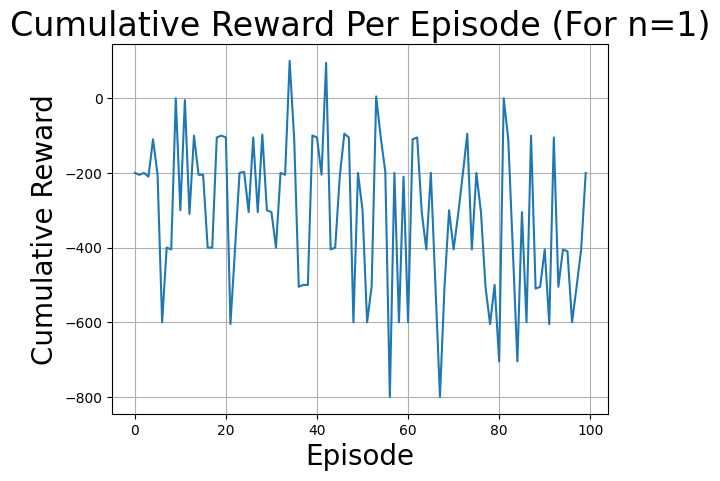

In [5]:
plt.figure()
plt.plot(rewards_1)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (For n=1)', fontsize=24)
plt.grid()
plt.show()

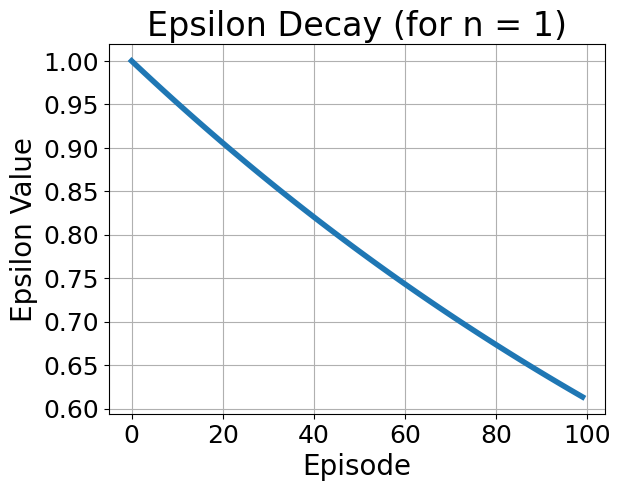

In [6]:
plt.figure()
plt.plot(epsilon_values_1, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay (for n = 1)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()

# For value n = 2

In [7]:
# env = GridEnvironment()
# Q1_table = np.zeros((env.observation_space.n, env.action_space.n))
# Q2_table = np.zeros((env.observation_space.n, env.action_space.n))

print("Intial Q1_table:",Q1_table)
print("\n")
print("Intial Q2_table:",Q2_table)


epsilon = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.005

learning_rate = 0.1
episodes = 100
gamma = 0.8
n = 2                   # 1

#iniitalize the arrays to store the values and plot graph
rewards_2 = []
epsilon_values_2 = []

for episode in range(episodes):
  obs, info = env.reset()
  terminated = False
  rewards_list = [0]
  actions_list = [2]
  state_number_list = [20]
  max_timesteps = 10
  tau = 0
  t = 0
  total_reward = 0

  while tau != max_timesteps-1:
    if t < max_timesteps:
      action = actions_list[t]
      obs, reward, terminated, truncated, info = env.step(action)
      next_state_number = np.where(obs == 1)[0][0]
      state_number_list.append(next_state_number)
      rewards_list.append(reward)
      total_reward += reward

      if terminated:
        max_timesteps = t + 1
      else:
        if np.random.uniform(0, 1) < epsilon:
          next_action = np.random.choice(env.action_space.n)
          actions_list.append(next_action)
        else:
          #adding the greedy epsilon selection that chooses action in Q1+Q2
          next_action = np.argmax(Q1_table[next_state_number] + Q2_table[next_state_number] )
          actions_list.append(next_action)
    tau = t - n + 1
    if tau >= 0:
      G = 0
      for i in range(tau+1, min(tau+n, max_timesteps)):
        G += gamma**(i-tau-1) * rewards_list[i]
      '''
      if tau + n < max_timesteps:
        #add the Double Q learning to calculate G
        if np.random.uniform(0,1) < 0.5:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        else:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
      '''
      #add the Double Q learning to update the Q-table
      if np.random.uniform(0,1) < 0.5:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        Q1_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q1_table[state_number_list[tau], actions_list[tau]])
      else:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
        Q2_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q2_table[state_number_list[tau], actions_list[tau]])
    t += 1

  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  rewards_2.append(total_reward)
  epsilon_values_2.append(epsilon)

  # print('episode:', episode, ', tau:', tau, ', t:', t)

print("Final Q1_table:",Q1_table)
print("\n")
print("Final Q2_table:",Q2_table)


Intial Q1_table: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Intial Q2_table: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Final Q1_table: [[ 2.59200000e-02 -1.90000000e+01  0.00000000e+00 -9.99991547e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.50000000e-01 -1.00000000e+01  0.00000000e+00  0.00000000e

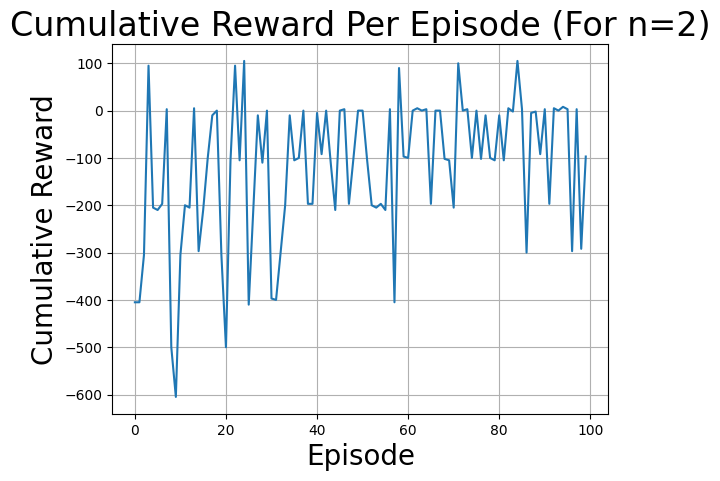

In [8]:
plt.figure()
plt.plot(rewards_2)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (For n=2)', fontsize=24)
plt.grid()
plt.show()

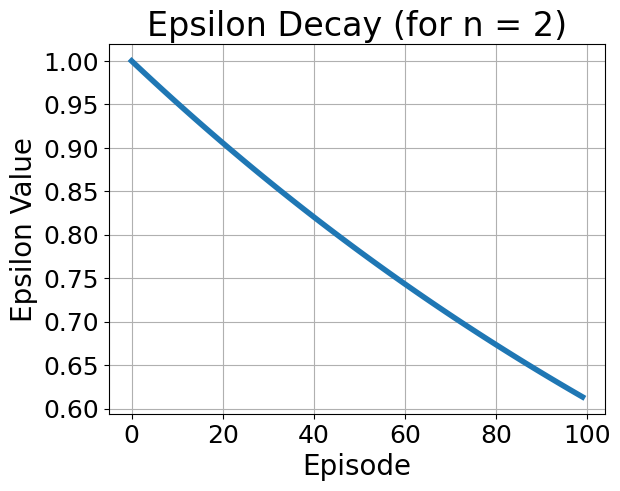

In [9]:
plt.figure()
plt.plot(epsilon_values_2, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay (for n = 2)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()

For value n = 3

In [10]:
# env = GridEnvironment()
# Q1_table = np.zeros((env.observation_space.n, env.action_space.n))
# Q2_table = np.zeros((env.observation_space.n, env.action_space.n))

print("Intial Q1_table:",Q1_table)
print("\n")
print("Intial Q2_table:",Q2_table)


epsilon = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.005

learning_rate = 0.1
episodes = 100
gamma = 0.8
n = 3                   # 3

#iniitalize the arrays to store the values and plot graph
rewards_3 = []
epsilon_values_3 = []

for episode in range(episodes):
  obs, info = env.reset()
  terminated = False
  rewards_list = [0]
  actions_list = [2]
  state_number_list = [20]
  max_timesteps = 10
  tau = 0
  t = 0
  total_reward = 0

  while tau != max_timesteps-1:
    if t < max_timesteps:
      action = actions_list[t]
      obs, reward, terminated, truncated, info = env.step(action)
      next_state_number = np.where(obs == 1)[0][0]
      state_number_list.append(next_state_number)
      rewards_list.append(reward)
      total_reward += reward

      if terminated:
        max_timesteps = t + 1
      else:
        if np.random.uniform(0, 1) < epsilon:
          next_action = np.random.choice(env.action_space.n)
          actions_list.append(next_action)
        else:
          #adding the greedy epsilon selection that chooses action in Q1+Q2
          next_action = np.argmax(Q1_table[next_state_number] + Q2_table[next_state_number] )
          actions_list.append(next_action)
    tau = t - n + 1
    if tau >= 0:
      G = 0
      for i in range(tau+1, min(tau+n, max_timesteps)):
        G += gamma**(i-tau-1) * rewards_list[i]
      '''
      if tau + n < max_timesteps:
        #add the Double Q learning to calculate G
        if np.random.uniform(0,1) < 0.5:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        else:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
      '''
      #add the Double Q learning to update the Q-table
      if np.random.uniform(0,1) < 0.5:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        Q1_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q1_table[state_number_list[tau], actions_list[tau]])
      else:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
        Q2_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q2_table[state_number_list[tau], actions_list[tau]])
    t += 1

  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  rewards_3.append(total_reward)
  epsilon_values_3.append(epsilon)

  # print('episode:', episode, ', tau:', tau, ', t:', t)

print("Final Q1_table:",Q1_table)
print("\n")
print("Final Q2_table:",Q2_table)


Intial Q1_table: [[ 2.59200000e-02 -1.90000000e+01  0.00000000e+00 -9.99991547e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.50000000e-01 -1.00000000e+01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.50969589e-02  7.30741907e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.75363672e+00  0.00000000e+00]
 [-1.24717143e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.73781236e-01  1.31472828e+00  3.15527876e-01 -1.89635200e+01]
 [-5.39537261e-03  2.13902478e-03  2.71155200e-04  1.23941147e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.43847659e-01]
 [-9.82000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000

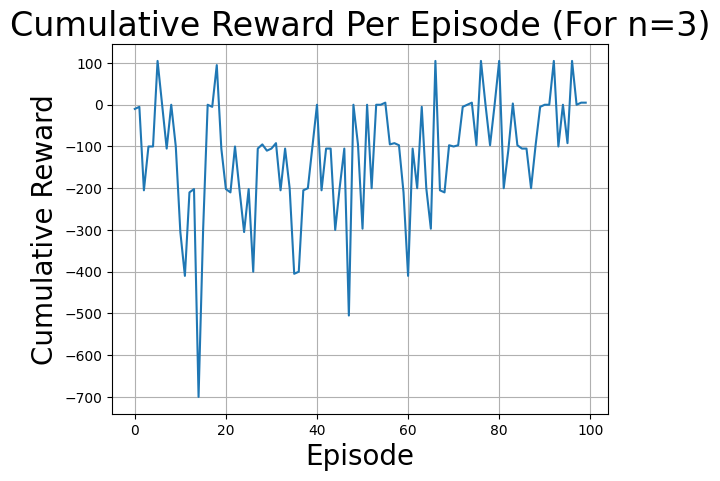

In [11]:
plt.figure()
plt.plot(rewards_3)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (For n=3)', fontsize=24)
plt.grid()
plt.show()

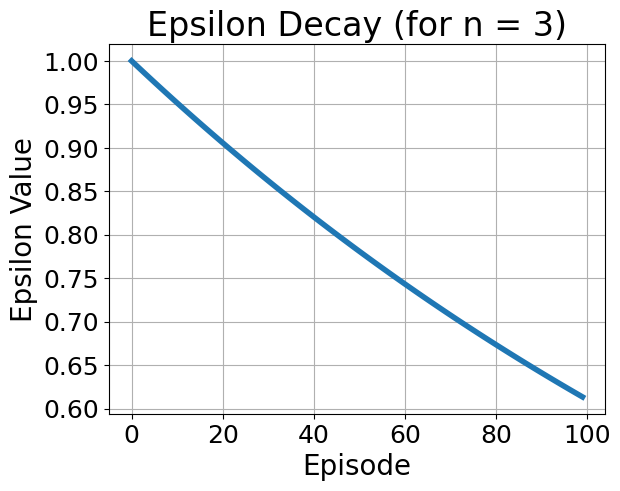

In [12]:
plt.figure()
plt.plot(epsilon_values_3, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay (for n = 3)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()

For value n = 4

In [13]:
# env = GridEnvironment()
# Q1_table = np.zeros((env.observation_space.n, env.action_space.n))
# Q2_table = np.zeros((env.observation_space.n, env.action_space.n))

print("Intial Q1_table:",Q1_table)
print("\n")
print("Intial Q2_table:",Q2_table)


epsilon = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.005

learning_rate = 0.1
episodes = 100
gamma = 0.8
n = 4                   # 4

#iniitalize the arrays to store the values and plot graph
rewards_4 = []
epsilon_values_4 = []

for episode in range(episodes):
  obs, info = env.reset()
  terminated = False
  rewards_list = [0]
  actions_list = [2]
  state_number_list = [20]
  max_timesteps = 10
  tau = 0
  t = 0
  total_reward = 0

  while tau != max_timesteps-1:
    if t < max_timesteps:
      action = actions_list[t]
      obs, reward, terminated, truncated, info = env.step(action)
      next_state_number = np.where(obs == 1)[0][0]
      state_number_list.append(next_state_number)
      rewards_list.append(reward)
      total_reward += reward

      if terminated:
        max_timesteps = t + 1
      else:
        if np.random.uniform(0, 1) < epsilon:
          next_action = np.random.choice(env.action_space.n)
          actions_list.append(next_action)
        else:
          #adding the greedy epsilon selection that chooses action in Q1+Q2
          next_action = np.argmax(Q1_table[next_state_number] + Q2_table[next_state_number] )
          actions_list.append(next_action)
    tau = t - n + 1
    if tau >= 0:
      G = 0
      for i in range(tau+1, min(tau+n, max_timesteps)):
        G += gamma**(i-tau-1) * rewards_list[i]
      '''
      if tau + n < max_timesteps:
        #add the Double Q learning to calculate G
        if np.random.uniform(0,1) < 0.5:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        else:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
      '''
      #add the Double Q learning to update the Q-table
      if np.random.uniform(0,1) < 0.5:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        Q1_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q1_table[state_number_list[tau], actions_list[tau]])
      else:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
        Q2_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q2_table[state_number_list[tau], actions_list[tau]])
    t += 1

  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  rewards_4.append(total_reward)
  epsilon_values_4.append(epsilon)

  # print('episode:', episode, ', tau:', tau, ', t:', t)

print("Final Q1_table:",Q1_table)
print("\n")
print("Final Q2_table:",Q2_table)


Intial Q1_table: [[-6.87900480e+00 -1.90000000e+01  0.00000000e+00 -9.99991547e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.83197105e-01]
 [ 7.73208490e-01 -1.00000000e+01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.27285367e-02 -7.99408099e+00  9.82056548e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.35774018e+00  5.70000000e-01]
 [ 7.83710787e-02 -5.83200667e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.37098424e-01 -6.02604285e+00  3.15527876e-01 -2.68219675e+01]
 [ 1.68042405e-02  1.73721317e+00  4.16390779e-01 -7.98148480e+00]
 [-2.84091846e-01  2.50016229e+00 -5.58025564e-01  1.90136218e-01]
 [-9.82000000e-01  0.00000000e+00  0.00000000e+00  4.95844401e-01]
 [ 0.00000000e+00 -8.00000000e+00  0.00000000

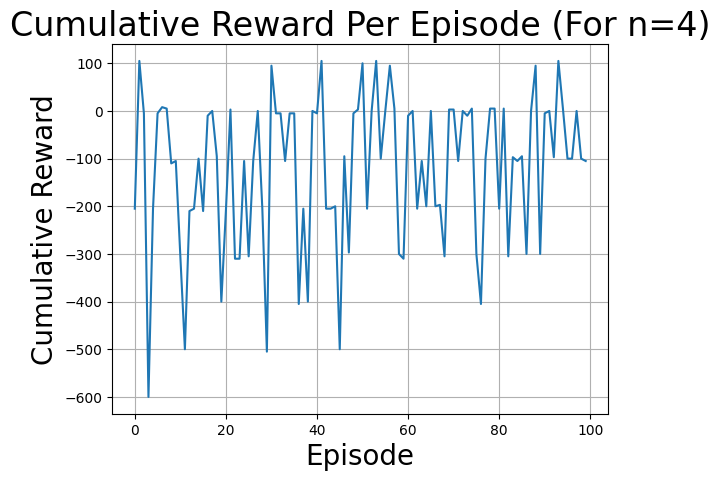

In [14]:
plt.figure()
plt.plot(rewards_4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (For n=4)', fontsize=24)
plt.grid()
plt.show()

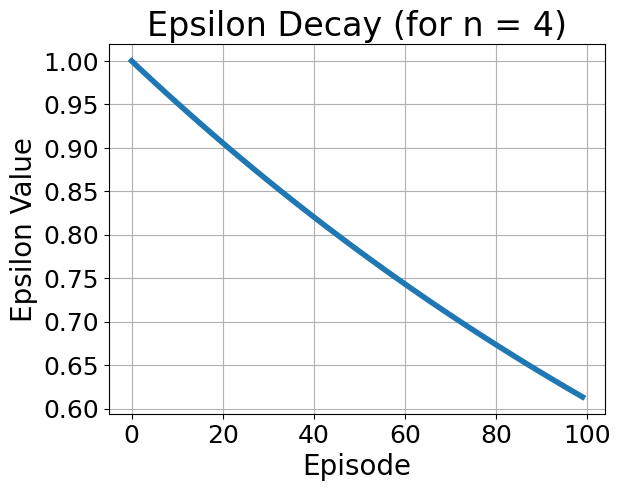

In [15]:
plt.figure()
plt.plot(epsilon_values_4, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay (for n = 4)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()

For value n = 5

In [21]:
# env = GridEnvironment()
# Q1_table = np.zeros((env.observation_space.n, env.action_space.n))
# Q2_table = np.zeros((env.observation_space.n, env.action_space.n))

print("Intial Q1_table:",Q1_table)
print("\n")
print("Intial Q2_table:",Q2_table)


epsilon = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.005

learning_rate = 0.1
episodes = 100
gamma = 0.8
n = 5                   #

#iniitalize the arrays to store the values and plot graph
rewards_5 = []
epsilon_values_5 = []

for episode in range(episodes):
  obs, info = env.reset()
  terminated = False
  rewards_list = [0]
  actions_list = [2]
  state_number_list = [20]
  max_timesteps = 10
  tau = 0
  t = 0
  total_reward = 0

  while tau != max_timesteps-1:
    if t < max_timesteps:
      action = actions_list[t]
      obs, reward, terminated, truncated, info = env.step(action)
      next_state_number = np.where(obs == 1)[0][0]
      state_number_list.append(next_state_number)
      rewards_list.append(reward)
      total_reward += reward

      if terminated:
        max_timesteps = t + 1
      else:
        if np.random.uniform(0, 1) < epsilon:
          next_action = np.random.choice(env.action_space.n)
          actions_list.append(next_action)
        else:
          #adding the greedy epsilon selection that chooses action in Q1+Q2
          next_action = np.argmax(Q1_table[next_state_number] + Q2_table[next_state_number] )
          actions_list.append(next_action)
    tau = t - n + 1
    if tau >= 0:
      G = 0
      for i in range(tau+1, min(tau+n, max_timesteps)):
        G += gamma**(i-tau-1) * rewards_list[i]
      '''
      if tau + n < max_timesteps:
        #add the Double Q learning to calculate G
        if np.random.uniform(0,1) < 0.5:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        else:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
      '''
      #add the Double Q learning to update the Q-table
      if np.random.uniform(0,1) < 0.5:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        Q1_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q1_table[state_number_list[tau], actions_list[tau]])
      else:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
        Q2_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q2_table[state_number_list[tau], actions_list[tau]])
    t += 1

  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  rewards_5.append(total_reward)
  epsilon_values_5.append(epsilon)

  # print('episode:', episode, ', tau:', tau, ', t:', t)

print("Final Q1_table:",Q1_table)
print("\n")
print("Final Q2_table:",Q2_table)


Intial Q1_table: [[ 0.00000000e+00 -5.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.72838481e-01 -9.75000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.02666058e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.45992525e+00  0.00000000e+00 -9.75000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.54415969e+00 -1.44539725e+00]
 [ 0.00000000e+00 -2.54104331e+00  0.00000000e+00 -3.11069602e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.31808586e+00 -3.15941328e+00 -3.51551393e+00 -2.67915295e+01]
 [ 4.39268036e-01 -3.67150018e+00  1.94584288e+00 -4.03928066e+00]
 [-8.98300054e-01  4.89503997e+00 -6.96995031e-01  1.39100353e+00]
 [-4.64343750e-01  0.00000000e+00 -4.95000000e+00  2.41035757e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.75000000

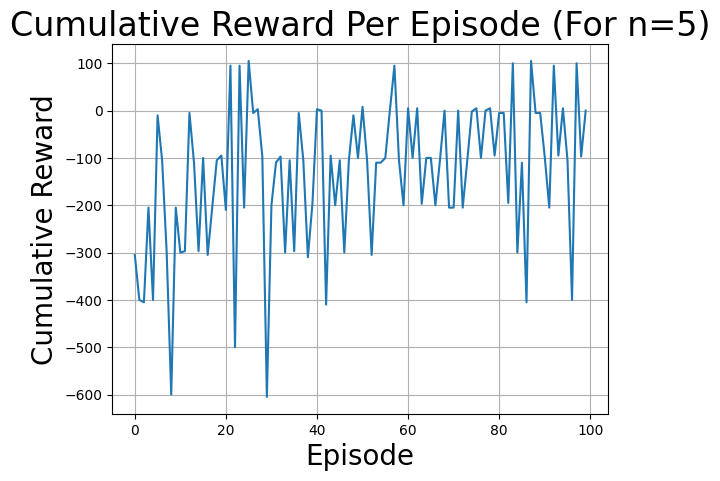

In [22]:
plt.figure()
plt.plot(rewards_5)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (For n=5)', fontsize=24)
plt.grid()
plt.show()

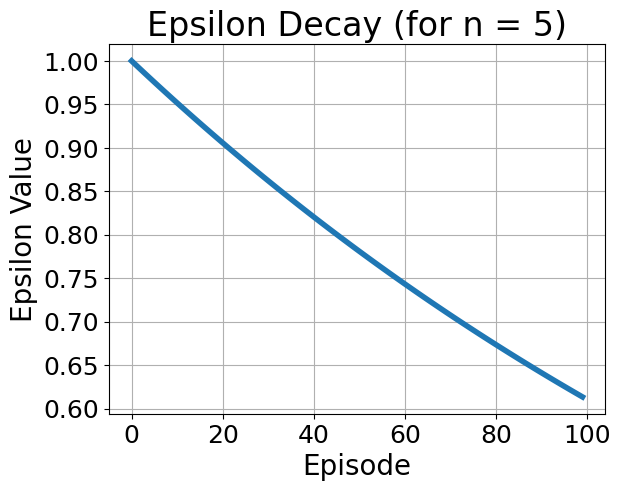

In [23]:
plt.figure()
plt.plot(epsilon_values_5, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay (for n = 5)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()

## Hyperparameters

Using n=5. Changing the hyperparameters:

## Hyperparameters

Using n=5. \
Changing the hyperparameters:
*   learning_rate = 0.05  #Hyperparameter #1
*   episodes = 800        #Hyperparameter #2
*   gamma = 0.99          #Hyperparameter #3


In [20]:
env = GridEnvironment()
Q1_table = np.zeros((env.observation_space.n, env.action_space.n))
Q2_table = np.zeros((env.observation_space.n, env.action_space.n))

# print("Intial Q1_table:",Q1_table)
# print("\n")
# print("Intial Q2_table:",Q2_table)


epsilon = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.005

learning_rate = 0.05  #Hyperparameter #1
episodes = 800        #Hyperparameter #2
gamma = 0.99          #Hyperparameter #3
n = 5

#iniitalize the arrays to store the values and plot graph
rewards_hyperparameter_tunning = []
epsilon_values_hyperparameter_tunning = []
total_reward = 0

start_time = time.time()

for episode in range(episodes):
  obs, info = env.reset()
  terminated = False
  rewards_list = [0]
  actions_list = [2]
  state_number_list = [20]
  max_timesteps = 10
  tau = 0
  t = 0
  total_reward = 0

  while tau != max_timesteps-1:
    if t < max_timesteps:
      action = actions_list[t]
      obs, reward, terminated, truncated, info = env.step(action)
      next_state_number = np.where(obs == 1)[0][0]
      state_number_list.append(next_state_number)
      rewards_list.append(reward)
      total_reward += reward

      if terminated:
        max_timesteps = t + 1
      else:
        if np.random.uniform(0, 1) < epsilon:
          next_action = np.random.choice(env.action_space.n)
          actions_list.append(next_action)
        else:
          #adding the greedy epsilon selection that chooses action in Q1+Q2
          next_action = np.argmax(Q1_table[next_state_number] + Q2_table[next_state_number] )
          actions_list.append(next_action)
    tau = t - n + 1
    if tau >= 0:
      G = 0
      for i in range(tau+1, min(tau+n, max_timesteps)):
        G += gamma**(i-tau-1) * rewards_list[i]
      '''
      if tau + n < max_timesteps:
        #add the Double Q learning to calculate G
        if np.random.uniform(0,1) < 0.5:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        else:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
      '''
      #add the Double Q learning to update the Q-table
      if np.random.uniform(0,1) < 0.5:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q1_table[next_state_number])
          G += gamma**n * Q2_table[next_state_number, action_choosen]
        Q1_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q1_table[state_number_list[tau], actions_list[tau]])
      else:
        if tau + n < max_timesteps:
          action_choosen = np.argmax(Q2_table[next_state_number])
          G += gamma**n * Q1_table[next_state_number, action_choosen]
        Q2_table[state_number_list[tau], actions_list[tau]] += learning_rate * (G - Q2_table[state_number_list[tau], actions_list[tau]])
    t += 1

  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  rewards_hyperparameter_tunning.append(total_reward)
  epsilon_values_hyperparameter_tunning.append(epsilon)

  # print('episode:', episode, ', tau:', tau, ', t:', t)

end_time  = time.time()
training_time = end_time - start_time


print(f"Training time for Hyperparameter: {training_time}")
print(f"Performance of training: {total_reward/episodes}")
print("\n")

print("Final Q1_table:",Q1_table)
print("\n")
print("Final Q2_table:",Q2_table)


Training time for Hyperparameter: 2.99157452583313
Performance of training: 0.13125


Final Q1_table: [[ 0.00000000e+00 -5.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.72838481e-01 -9.75000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.02666058e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.45992525e+00  0.00000000e+00 -9.75000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.54415969e+00 -1.44539725e+00]
 [ 0.00000000e+00 -2.54104331e+00  0.00000000e+00 -3.11069602e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.31808586e+00 -3.15941328e+00 -3.51551393e+00 -2.67915295e+01]
 [ 4.39268036e-01 -3.67150018e+00  1.94584288e+00 -4.03928066e+00]
 [-8.98300054e-01  4.89503997e+00 -6.96995031e-01  1.39100353e+00]
 [-4.64343750e-01  0.000000

## Compare SARSA and N-Step Double Q Learnings

SARSA Intial Setup from Part 2

In [24]:
env = GridEnvironment()

#intial Q-table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# print("Intial Q-table")
# print(Q_table)

#epsilon decay values
epsilon_value_initial = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.005

learning_rate = 0.1  #alpha
episodes = 1000
gamma = 0.8

total_step = 0

#iniitalize the arrays to store the values and plot graph
rewards_sarsa = []
epsilon_values_sarsa = []

for episode in range(episodes):

  #starting S
  obs, info = env.reset()
  step = 0
  total_rewards = 0

  # obs = obs.astype(int) #old code
  # print(obs)

  # getting the correct state index of the agent to update the Q-table
  state_number = np.where(obs == 1)[0][0]

  # print("Intial State Number is:",state_number)
  # print(type(state_number))

  #choose A from S, using the epsilon greedy policy
  if np.random.uniform(0,1) < epsilon_value_initial:
    action = np.random.choice(env.action_space.n)
  else:
    action = np.argmax(Q_table[state_number])

  # print("Action is:",action)

  terminated, truncated = False, False

  while not terminated:

    total_step += 1

    #collect the next S
    next_obs, reward, terminated, truncated, info = env.step(action)

    #convert to int values for finding argmax
    # next_obs = next_obs.astype(int)

    next_state_number = np.where(next_obs == 1)[0][0]   #next state index for Q-table

    # choose A' from S'(based on new_obs) then that along with intial action will be used to calculate the sarsa update
    if np.random.uniform(0,1) < epsilon_value_initial:
      next_action = np.random.choice(env.action_space.n)
    else:
      next_action = np.argmax(Q_table[next_state_number])

    #update the Q_table
    Q_table[state_number,action] += learning_rate * (reward + gamma * Q_table[next_state_number,next_action] - Q_table[state_number,action])

    state_number = next_state_number   #set state to next_state value
    action = next_action
    total_rewards += reward
    step += 1

    if terminated or truncated:
      break

  rewards_sarsa.append(total_rewards)
  epsilon_value_initial = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  epsilon_values_sarsa.append(epsilon_value_initial)

# print("Total Steps:", total_step)
# print("\nFinal Q-table")
# print(Q_table)


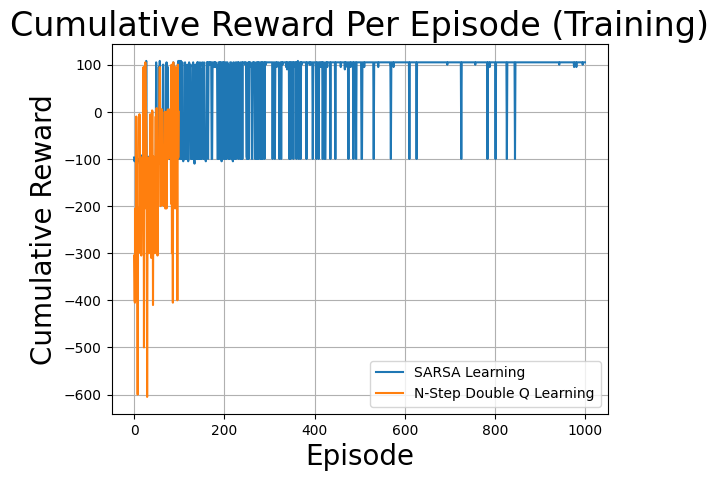

In [27]:
plt.figure()
plt.plot(rewards_sarsa, label="SARSA Learning")
plt.plot(rewards_5, label="N-Step Double Q Learning")
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (Training)', fontsize=24)
plt.legend()
plt.grid()
plt.show()